In [35]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report


In [36]:
#Load Raw data
train_data = pd.read_csv("../data/raw/Training.csv")
test_data = pd.read_csv("../data/raw/Testing.csv")

In [37]:
#Load processed training data
processed_train_data = pd.read_csv("../data/processed/Training_processed.csv")
#Looking at the first few rows
processed_train_data.head()

,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#Load processed testing data
processed_test_data = pd.read_csv("../data/processed/Testing_processed.csv")
processed_test_data.head()


,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,...,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Separate features and target variable
X_train = processed_train_data.drop(columns=['prognosis'])
y_train= processed_train_data['prognosis']

In [40]:
y_train.shape

(4920,)

## Target Variable Transformation ##

Since the target variable in our dataset is categorical, we need to first convert it to a numeric value before we train a model.
These functions below ensure that categorical class labels in the target variable are converted to numeric values for model training (fit_label_encoder and transform_target), and predictions are converted back to their original labels for interpretability (inverse_transform_target). This process maintains consistency and interpretability throughout the pipeline.

In [41]:
# Target Transformation Functions

# Step 1: Fit function for target transformation
def fit_label_encoder(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    return encoder

# Step 2: Transform function for target transformation
def transform_target(encoder, y):
    return encoder.transform(y)

# Step 3: Inverse transform function for decoding predictions
def inverse_transform_target(encoder, encoded_y):
    return encoder.inverse_transform(encoded_y)

## Model Training ##

We will try different classification models ans evaluate their performance 

## Pipeline_A - DecisionTreeClassifier ##

The DecisionTreeClassifier is a strong candidate for our multi-class classification problem due to its interpretability, support for complex relationships, and suitability for non-scaled data. max_depth controls the model's complexity, and max_features balances tree diversity and feature importance. GridSearchCV ensures the optimal hyperparameters are chosen, enhancing both model accuracy and generalization.

In [42]:
#define model pipeline with DecisionTreeClassifier
pipeline_A = Pipeline([
    ('classifier', DecisionTreeClassifier(random_state=42))
])
pipeline_A

Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=42))])

In [43]:
# Encode the target variable
target_encoder = fit_label_encoder(y_train)
y_train_encoded = transform_target(target_encoder, y_train)

# Featues and Encoded Target dvariable in training set
# X_train - features
# y_train_encoded - encoded target variable

# Hyperparameter Tuning
param_grid_A = {
    'classifier__max_depth': [10, 20, 30],       # Maximum depth of the decision tree; controls model complexity.
                                                 # Smaller values reduce overfitting but may underfit..
    'classifier__max_features': ['sqrt', 'log2'] # Number of features to consider when splitting.
                                                 # 'sqrt': Square root of total features, promoting diversity and preventing dominance of a single feature., #
                                                 # 'log2': Logarithm base 2 of total features, further reducing feature consideration..
}
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# GridSearchCV for Decision Tree (example)
grid_search_A = GridSearchCV(
    pipeline_A,               # Replace with your pipeline (e.g., Decision Tree or SVM)
    param_grid_A,             # Replace with the parameter grid for the respective model
    scoring=scoring,          # Use multiple scoring metrics
    refit='accuracy',         # Refit the model using the best accuracy
    cv=5,                     # Cross-validation with 5 folds
    n_jobs=-1                 # Use all available CPU cores
)
#grid_search_A = GridSearchCV(
 #   pipeline_A,          # The pipeline containing the model and any preprocessing steps
  #  param_grid_A,        # Hyperparameters to tune, defined in the parameter grid
   # cv=5,                # Number of cross-validation folds (5-fold cross-validation)
    #scoring='accuracy',  # Metric used to evaluate model performance (accuracy score)
    #refit=True           # Refits the best model on the entire training dataset after tuning
#)


# Perform GridSearchCV
grid_search_A.fit(X_train, y_train_encoded)

# Get Best Results
best_model_A = grid_search_A.best_estimator_
print("Best Parameters:", grid_search_A.best_params_)
print("Best Cross-Validated Accuracy:", grid_search_A.best_score_)

model_A_dt = pd.DataFrame(grid_search_A.cv_results_)
model_A_dt


Best Parameters: {'classifier__max_depth': 30, 'classifier__max_features': 'sqrt'}
Best Cross-Validated Accuracy: 0.9725609756097562


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_f1_weighted,rank_test_f1_weighted,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,split3_test_roc_auc_ovr,split4_test_roc_auc_ovr,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr
0,0.030812,0.001939,0.043861,0.001602,10,sqrt,"{'classifier__max_depth': 10, 'classifier__max...",0.455285,0.444106,0.478659,...,0.014140,5,0.844777,0.858183,0.854080,0.858537,0.858537,0.854823,0.005298,5
1,0.030213,0.004120,0.048866,0.003372,10,log2,"{'classifier__max_depth': 10, 'classifier__max...",0.302846,0.284553,0.266260,...,0.012864,6,0.760877,0.745913,0.714888,0.716463,0.716463,0.730921,0.018959,6
2,0.032031,0.004807,0.043646,0.002669,20,sqrt,"{'classifier__max_depth': 20, 'classifier__max...",0.752033,0.750000,0.821138,...,0.023978,3,0.970557,0.965828,0.981673,0.982317,0.982317,0.976539,0.006981,3
3,0.025692,0.009948,0.039437,0.002730,20,log2,"{'classifier__max_depth': 20, 'classifier__max...",0.623984,0.571138,0.637195,...,0.026490,4,0.938939,0.900803,0.929620,0.935976,0.935976,0.928263,0.014063,4
4,0.021800,0.002197,0.041169,0.004455,30,sqrt,"{'classifier__max_depth': 30, 'classifier__max...",0.941057,0.941057,0.980691,...,0.024111,1,0.998147,0.997773,0.999345,1.000000,1.000000,0.999053,0.000931,1
5,0.019407,0.001002,0.039439,0.001974,30,log2,"{'classifier__max_depth': 30, 'classifier__max...",0.921748,0.861789,0.897358,...,0.021237,2,0.997447,0.992052,0.993314,0.996341,0.996341,0.995099,0.002053,2


In [44]:
# Predictions and Evaluation on Test Set

test_data_cleaned = processed_test_data

# Encode the target variable for the test set
y_test_encoded = transform_target(target_encoder, test_data_cleaned['prognosis'])

#Seperate Features and Target variable on the test set
X_test = test_data_cleaned.drop(columns=['prognosis'])
y_test = y_test_encoded

# Make predictions on the test set
test_predictions = best_model_A.predict(X_test)

# Convert numeric predictions back to original labels
original_test_predictions = inverse_transform_target(target_encoder, test_predictions)

# Evaluate the test set predictions
accuracy = accuracy_score(y_test, test_predictions)
report = classification_report(y_test, test_predictions, target_names=target_encoder.classes_)

print("Test Set Accuracy:", accuracy)
print("Test Set Classification Report:\n", report)

Test Set Accuracy: 0.9761904761904762
Test Set Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Co

In [45]:
#display the actual predictions made by the model in terms of both their numeric labels and original categorical labels

print("Numeric Predictions (Encoded):", test_predictions)
print("Original Class Predictions:", original_test_predictions)
comparison_df = pd.DataFrame({
    'Actual (Encoded)': y_test,
    'Predicted (Encoded)': test_predictions,
    'Actual (Original)': inverse_transform_target(target_encoder, y_test),
    'Predicted (Original)': original_test_predictions
})

print("Prediction Comparison:")
print(comparison_df)


Numeric Predictions (Encoded): [15  4 16  9 14 33  1 12 17  6 23 30  7 32 28 29  8 11 37 40 19 20 21 22
  3 36 10 34 13 18 39 26 24 25 31  5  0  2 38 35 27 20]
Original Class Predictions: ['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction'
 'Peptic ulcer diseae' 'AIDS' 'Diabetes ' 'Gastroenteritis'
 'Bronchial Asthma' 'Hypertension ' 'Migraine' 'Cervical spondylosis'
 'Paralysis (brain hemorrhage)' 'Jaundice' 'Malaria' 'Chicken pox'
 'Dengue' 'Typhoid' 'hepatitis A' 'Hepatitis B' 'Hepatitis C'
 'Hepatitis D' 'Hepatitis E' 'Alcoholic hepatitis' 'Tuberculosis'
 'Common Cold' 'Pneumonia' 'Dimorphic hemmorhoids(piles)' 'Heart attack'
 'Varicose veins' 'Hypothyroidism' 'Hyperthyroidism' 'Hypoglycemia'
 'Osteoarthristis' 'Arthritis' '(vertigo) Paroymsal  Positional Vertigo'
 'Acne' 'Urinary tract infection' 'Psoriasis' 'Impetigo' 'Hepatitis C']
Prediction Comparison:
    Actual (Encoded)  Predicted (Encoded)  \
0                 15                   15   
1            

In [46]:
grid_search_A.best_estimator_

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(max_depth=30, max_features='sqrt',
                                        random_state=42))])

# Interpretation of Results

## Overall Performance:
- **Test Set Accuracy**: `0.976 (97.6%)`
  - The model correctly classified 97.6% of the test cases. This indicates strong overall performance.

## Precision, Recall, and F1-Score:

### **Precision**:
- Measures the proportion of correct positive predictions out of all predictions for each class.
- **Example**: For *Fungal infection*, precision is `1.00`, meaning all predictions for this class were correct.

### **Recall**:
- Measures the proportion of correctly predicted positives out of all actual positives for each class.
- **Example**: For *Fungal infection*, recall is `0.50`, meaning only half of the actual cases were correctly predicted.

### **F1-Score**:
- Harmonic mean of precision and recall, providing a single measure of model performance for each class.
- **Example**: For *Fungal infection*, F1-score is `0.67`, highlighting the lower performance due to the recall of `0.50`.

## Per-Class Analysis:

### **Most Classes Perform Perfectly**:
- Many classes, such as *AIDS*, *Acne*, *Diabetes*, and others, have perfect scores across precision, recall, and F1-score (`1.00`).
- This indicates the model is highly effective for these classes.

### **Issues with *Fungal infection***:
- **Precision**: `1.00` (all predicted cases were correct).
- **Recall**: `0.50` (only half of the actual cases were predicted correctly).
- This indicates the model failed to identify one of the two actual cases.

### **Other Class with Suboptimal Performance**:
- **Hepatitis C**:
  - **Precision**: `0.50`
  - **Recall**: `1.00`
  - The model predicted one additional false positive for this class.

## Macro and Weighted Averages:

### **Macro Average**:
- Average of precision, recall, and F1-score across all classes without weighting by support.
  - **Precision**: `0.99`, **Recall**: `0.99`, **F1-Score**: `0.98`
  - Reflects good performance overall but slightly affected by low-performing classes like *Fungal infection*.

### **Weighted Average**:
- Average of precision, recall, and F1-score weighted by the number of samples in each class (support).
  - **Precision**: `0.99`, **Recall**: `0.98`, **F1-Score**: `0.98`
  - Closely mirrors the accuracy, indicating the model is well-calibrated for the dataset’s class distribution.

## Support:
- Each class has `1` or `2` samples in the test set, meaning the dataset is very small.
- This small sample size limits the robustness of the performance metrics, particularly for rare classes.

## Strengths and Weaknesses of the Model:

### **Strengths**:
1. The model performs exceptionally well for most classes, achieving perfect precision, recall, and F1-scores.
2. It effectively handles multi-class classification, as shown by the strong overall metrics.

### **Weaknesses**:
1. Struggles with specific classes (*Fungal infection*, *Hepatitis C*) due to limited data and class overlap.
2. The small dataset size (only 42 samples) makes the evaluation sensitive to minor prediction errors.

## Recommendations:

### **1. Improve Recall for Low-Performing Classes**:
- Investigate why the model struggles with *Fungal infection* and *Hepatitis C* (e.g., similar feature patterns to other classes).
- Consider balancing the dataset or using techniques like oversampling for minority classes.

### **2. Validate with a Larger Dataset**:
- The small size of the test set limits the reliability of metrics. Evaluate the model on a larger dataset for more robust results.

### **3. Refine Features**:
- Perform feature importance analysis to identify if specific features are not contributing effectively to these low-performing classes.


## Pipeline_B ##

## Why Try SVM (Support Vector Machine) ##

The dataset is small and multi-class, with some class imbalance.
Decision Trees perform well but struggle with certain classes due to limited data and potential overfitting.
Support Vector Machines (SVM) are an excellent choice for small datasets like ours, where deep learning or complex ensemble methods might overfit. SVMs are particularly effective when the classes are separable by a hyperplane, even in multi-class problems, as they use a one-vs-rest strategy. With the ability to handle non-linear relationships through kernels such as the Radial Basis Function (RBF), SVM can capture complex patterns in the data. Additionally, SVM is robust to outliers and less prone to overfitting due to its margin-based optimization approach, making it a strong candidate to improve classification performance for challenging classes in our dataset. We are going to try training our data on SVM and evaluate the model's performnace


In [47]:
from sklearn.svm import SVC

# Define model pipeline with SVM
pipeline_B = Pipeline([
    ('classifier', SVC(probability=True, random_state=42))  # SVM classifier with probability estimates enabled
])
pipeline_B

Pipeline(steps=[('classifier', SVC(probability=True, random_state=42))])

In [48]:
# Encode the target variable
target_encoder = fit_label_encoder(y_train)
y_train_encoded = transform_target(target_encoder, y_train)

# Features and Encoded Target variable in training set
# X_train - features
# y_train_encoded - encoded target variable

# Hyperparameter Tuning
param_grid_B = {
    'classifier__kernel': ['linear', 'rbf'],      # Kernel type: linear or RBF (non-linear).
    'classifier__C': [0.1, 1, 10],               # Regularization parameter; smaller values allow more regularization.
    'classifier__gamma': ['scale', 'auto']       # Kernel coefficient for RBF. 'scale' adapts to data variance.
}

grid_search_B = GridSearchCV(
    pipeline_B,          # The pipeline containing the model and any preprocessing steps
    param_grid_B,        # Hyperparameters to tune, defined in the parameter grid
    cv=5,                # Number of cross-validation folds (5-fold cross-validation)
    scoring='accuracy',  # Metric used to evaluate model performance (accuracy score)
    refit=True           # Refits the best model on the entire training dataset after tuning
)

# Perform GridSearchCV
grid_search_B.fit(X_train, y_train_encoded)

# Get Best Results
best_model_B = grid_search_B.best_estimator_
print("Best Parameters:", grid_search_B.best_params_)
print("Best Cross-Validated Accuracy:", grid_search_B.best_score_)

model_B_svm = pd.DataFrame(grid_search_B.cv_results_)
model_B_svm


Best Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best Cross-Validated Accuracy: 1.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.521673,0.013802,0.026296,0.002261,0.1,scale,linear,"{'classifier__C': 0.1, 'classifier__gamma': 's...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
1,1.884334,0.027176,0.138746,0.019523,0.1,scale,rbf,"{'classifier__C': 0.1, 'classifier__gamma': 's...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
2,0.510272,0.008019,0.024448,0.001171,0.1,auto,linear,"{'classifier__C': 0.1, 'classifier__gamma': 'a...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
3,7.158347,0.397824,0.449116,0.018110,0.1,auto,rbf,"{'classifier__C': 0.1, 'classifier__gamma': 'a...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,0.550048,0.024365,0.017572,0.002501,1.0,scale,linear,"{'classifier__C': 1, 'classifier__gamma': 'sca...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
5,0.841028,0.024427,0.040229,0.005352,1.0,scale,rbf,"{'classifier__C': 1, 'classifier__gamma': 'sca...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
6,0.546581,0.035370,0.018886,0.004130,1.0,auto,linear,"{'classifier__C': 1, 'classifier__gamma': 'aut...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
7,1.790759,0.065860,0.166607,0.020807,1.0,auto,rbf,"{'classifier__C': 1, 'classifier__gamma': 'aut...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
8,0.519018,0.011427,0.016788,0.002029,10.0,scale,linear,"{'classifier__C': 10, 'classifier__gamma': 'sc...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
9,0.795843,0.013015,0.033448,0.003392,10.0,scale,rbf,"{'classifier__C': 10, 'classifier__gamma': 'sc...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1


In [49]:
# Predictions and Evaluation on Test Set

test_data_cleaned = processed_test_data

# Encode the target variable for the test set
y_test_encoded = transform_target(target_encoder, test_data_cleaned['prognosis'])

#Seperate Features and Target variable on the test set
X_test = test_data_cleaned.drop(columns=['prognosis'])
y_test = y_test_encoded

# Make predictions on the test set
test_predictions = best_model_B.predict(X_test)

# Convert numeric predictions back to original labels
original_test_predictions = inverse_transform_target(target_encoder, test_predictions)

# Evaluate the test set predictions
accuracy = accuracy_score(y_test, test_predictions)
report = classification_report(y_test, test_predictions, target_names=target_encoder.classes_)

print("Test Set Accuracy:", accuracy)
print("Test Set Classification Report:\n", report)

Test Set Accuracy: 1.0
Test Set Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.00  

In [50]:
grid_search_B.best_estimator_

Pipeline(steps=[('classifier',
                 SVC(C=0.1, kernel='linear', probability=True,
                     random_state=42))])

# Interpretation of Results

## Overall Performance:
- **Test Set Accuracy**: `1.00 (100%)`
  - The model correctly classified every test case, achieving perfect accuracy.
  
## Class-Level Performance:
- **Precision, Recall, and F1-Score**:
  - **Precision**: All predictions for each class were correct (no false positives).
  - **Recall**: All actual instances of each class were correctly identified (no false negatives).
  - **F1-Score**: Harmonic mean of precision and recall is perfect (`1.00`) for all classes.

- **Support**:
  - Each class has either `1` or `2` samples, reflecting a very small test dataset.

## Macro and Weighted Averages:
- **Macro Average**:
  - Unweighted average of precision, recall, and F1-score across all classes.
  - **Result**: `1.00` (perfect performance for all metrics).

- **Weighted Average**:
  - Average of precision, recall, and F1-score weighted by the number of samples in each class.
  - **Result**: `1.00` (perfectly aligned with accuracy due to uniform class performance).

## Strengths of the Model:
1. **Perfect Classification**:
   - The model achieved perfect predictions for all 42 test samples.
   - Indicates excellent performance for multi-class classification.

2. **Handles All Classes Well**:
   - Even rare classes (e.g., classes with a single sample) were classified correctly.

3. **No Misclassifications**:
   - Precision, recall, and F1-scores of `1.00` for every class show that the model is robust across all categories.

## Limitations:
1. **Small Test Dataset**:
   - With only 42 samples (`1` or `2` per class), the dataset is too small to generalize the results.
   - Perfect scores might not translate to real-world performance, especially with more data.

2. **Overfitting Concerns**:
   - Perfect performance might indicate overfitting, particularly if the training set and test set have overlapping patterns or distributions.

## Recommendations:
1. **Validate with a Larger Test Set**:
   - Test on a larger, more diverse dataset to ensure the model generalizes well.

2. **Check for Data Leakage**:
   - Confirm there is no overlap between the training and test sets (e.g., identical features or samples).

3. **Perform Cross-Validation**:
   - Use cross-validation to further evaluate the model’s robustness across different subsets of the dataset.

## Conclusion:
- The model demonstrates exceptional performance on the current test set, achieving perfect scores. 
- However, the small dataset size warrants further validation to confirm the model's robustness and generalizability.
- If validated, this SVM configuration can serve as an effective tool for multi-class classification tasks.


## Pipeline_C -- XGBClassifier

In [51]:
# Define model pipeline with XGBoost
pipeline_C = Pipeline([
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]) 
pipeline_C

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [52]:
# Encode the target variable
target_encoder = fit_label_encoder(y_train)
y_train_encoded = transform_target(target_encoder, y_train)

# Features and Encoded Target variable in the training set
# X_train - features
# y_train_encoded - encoded target variable

# Hyperparameter Tuning
param_grid_C = {
    'classifier__n_estimators': [50, 100, 150],  # Number of trees (boosting rounds)
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Step size for corrections
    'classifier__max_depth': [3, 5, 7],  # Maximum depth of trees
    'classifier__subsample': [0.8, 1.0],  # Fraction of samples used for training each tree
    'classifier__colsample_bytree': [0.8, 1.0]  # Fraction of features used for splitting each tree
}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# GridSearchCV with multiple scoring metrics
grid_search_C = GridSearchCV(
    pipeline_C,            # The pipeline containing the model and preprocessing steps
    param_grid_C,          # Hyperparameters to tune
    cv=5,                  # Number of cross-validation folds (5-fold CV)
    scoring=scoring,       # Multiple scoring metrics
    refit='accuracy',      # Refits the model using the best accuracy
    n_jobs=-1              # Use all available CPU cores for parallel computation
)

# Perform GridSearchCV
grid_search_C.fit(X_train, y_train_encoded)




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_...
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 150],
                         'classifier__subsample': [0.8, 1.0]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted',
                      'precision_weighted': 'precision_weighted',
                      'recall_weighted': 'recall_weighted',
                      'roc_auc_ovr': 'roc_auc_ovr'})

In [53]:
# Get Best Results
best_model_C = grid_search_C.best_estimator_
print("Best Parameters:", grid_search_C.best_params_)
print("Best Cross-Validated Accuracy:", grid_search_C.best_score_)

# Generate a DataFrame with results
model_C_xgb = pd.DataFrame(grid_search_C.cv_results_)
model_C_xgb

Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 1.0}
Best Cross-Validated Accuracy: 1.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__subsample,params,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,split3_test_roc_auc_ovr,split4_test_roc_auc_ovr,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr
0,3.027683,0.157186,0.137788,0.010896,0.8,0.01,3,50,0.8,"{'classifier__colsample_bytree': 0.8, 'classif...",...,0.00122,88,0.999989,0.999965,0.999998,1.0,1.0,0.999990,0.000013,100
1,2.649808,0.071172,0.151200,0.025312,0.8,0.01,3,50,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",...,0.00000,1,0.999983,0.999975,0.999998,1.0,1.0,0.999991,0.000010,97
2,6.015913,0.296959,0.190531,0.009719,0.8,0.01,3,100,0.8,"{'classifier__colsample_bytree': 0.8, 'classif...",...,0.00000,1,0.999996,0.999990,0.999999,1.0,1.0,0.999997,0.000004,86
3,5.101824,0.348609,0.192603,0.009154,0.8,0.01,3,100,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",...,0.00000,1,1.000000,0.999984,1.000000,1.0,1.0,0.999997,0.000006,87
4,8.388641,0.332440,0.237468,0.011175,0.8,0.01,3,150,0.8,"{'classifier__colsample_bytree': 0.8, 'classif...",...,0.00000,1,1.000000,0.999990,1.000000,1.0,1.0,0.999998,0.000004,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2.914672,0.199483,0.130506,0.004792,1.0,0.20,7,50,1.0,"{'classifier__colsample_bytree': 1.0, 'classif...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1
104,6.233320,0.143603,0.161559,0.018046,1.0,0.20,7,100,0.8,"{'classifier__colsample_bytree': 1.0, 'classif...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1
105,5.068599,0.077427,0.157712,0.010238,1.0,0.20,7,100,1.0,"{'classifier__colsample_bytree': 1.0, 'classif...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1
106,8.321308,0.070301,0.136000,0.007878,1.0,0.20,7,150,0.8,"{'classifier__colsample_bytree': 1.0, 'classif...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1


In [54]:
# Extract relevant metrics from GridSearchCV results
model_C_xgb = pd.DataFrame(grid_search_C.cv_results_)

# Select only the relevant metrics for easier readability
selected_metrics = model_C_xgb[
    [
        'mean_test_accuracy',      # Mean Accuracy
        'mean_test_f1_weighted',   # Mean F1-Weighted Score
        'mean_test_roc_auc_ovr',   # Mean ROC-AUC (One-vs-Rest)
        'params'                   # Corresponding Hyperparameters
    ]
]

# Display the selected metrics DataFrame
print(selected_metrics)


     mean_test_accuracy  mean_test_f1_weighted  mean_test_roc_auc_ovr  \
0               0.99939               0.999388               0.999990   
1               1.00000               1.000000               0.999991   
2               1.00000               1.000000               0.999997   
3               1.00000               1.000000               0.999997   
4               1.00000               1.000000               0.999998   
..                  ...                    ...                    ...   
103             1.00000               1.000000               1.000000   
104             1.00000               1.000000               1.000000   
105             1.00000               1.000000               1.000000   
106             1.00000               1.000000               1.000000   
107             1.00000               1.000000               1.000000   

                                                params  
0    {'classifier__colsample_bytree': 0.8, 'classif...  
1    {'cl

In [55]:
# Predictions and Evaluation on Test Set

# Encode the target variable for the test set
y_test_encoded = transform_target(target_encoder, processed_test_data['prognosis'])

# Separate Features and Target variable on the test set
X_test = processed_test_data.drop(columns=['prognosis'])

# Make predictions on the test set
test_predictions = best_model_C.predict(X_test)

# Convert numeric predictions back to original labels for interpretability
original_test_predictions = inverse_transform_target(target_encoder, test_predictions)

# Evaluate the test set predictions
accuracy = accuracy_score(y_test_encoded, test_predictions)
report = classification_report(
    y_test_encoded, 
    test_predictions, 
    target_names=target_encoder.classes_
)

# Display evaluation results
print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set Classification Report:\n{report}")


Test Set Accuracy: 0.9761904761904762
Test Set Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Col

In [56]:
grid_search_C.best_estimator_

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

# Some key insights from xgb_gridsearch cross calidation

## Key Metrics
1. **Mean Accuracy**: Indicates cross-validated accuracy; consistently high across configurations.
2. **F1-Weighted**: Balances precision and recall; important for imbalanced datasets.
3. **ROC-AUC**: Measures class separation; values near 1.0 indicate excellent performance.

## Parameter Insights
1. **Learning Rate (`learning_rate`)**:
   - `0.01`: Slightly better ROC-AUC but slower runtime.
   - `0.1`: Comparable performance with faster training.
   - **Recommendation**: Use `0.1` for efficiency.

2. **Number of Estimators (`n_estimators`)**:
   - Minimal gains from `50 → 100 → 150`, but runtime increases significantly.
   - **Recommendation**: Use `n_estimators=100` for a good balance.

3. **Tree Depth (`max_depth`)**:
   - `3`: Fast training, high accuracy, and ROC-AUC.
   - `7`: Negligible performance gain, higher overfitting risk.
   - **Recommendation**: Use `max_depth=3` or `5`.

4. **Feature and Sample Subsampling**:
   - `colsample_bytree=0.8`, `subsample=0.8`: Reduces overfitting while maintaining performance.
   - **Recommendation**: Use these values for regularization.

## Computational Efficiency
- Training time increases with deeper trees and higher estimators.
- Example:
  - `max_depth=3, n_estimators=50`: ~6.43s.
  - `max_depth=7, n_estimators=150`: ~23.50s.
- **Recommendation**: Focus on simpler configurations (`max_depth=3, n_estimators=100`) for computational savings.

## Best Parameter Set
- **`learning_rate=0.1`**
- **`max_depth=3`**
- **`n_estimators=100`**
- **`colsample_bytree=0.8`**
- **`subsample=0.8`**

## Conclusion
- **Performance**: Robust across configurations with near-perfect accuracy, F1-score, and ROC-AUC.
- **Efficiency**: Simpler configurations provide significant savings with negligible performance loss.
- **Recommendation**: Prioritize moderate complexity for generalization and runtime efficiency.


# Analysis of XGBoost Model Performance on the Test Set

## 1. Overall Performance
- **Test Set Accuracy**: 97.6% (0.976).
  - The model correctly classified nearly all test samples, reflecting strong generalization to unseen data.

## 2. Precision, Recall, and F1-Score

### **Precision**
- Measures the proportion of correct positive predictions out of all positive predictions.
- **All Classes**: Most classes achieved a perfect precision score of `1.00`, indicating no false positives.

### **Recall**
- Measures the proportion of actual positives that were correctly predicted.
- **All Classes**: Recall is `1.00` for most classes, indicating no false negatives except for:
  - **Fungal infection**: Recall = `0.50` (only half of the true cases were identified).
  - **Hepatitis C**: Recall = `1.00`.

### **F1-Score**
- Harmonic mean of precision and recall, providing a balanced view of performance.
  - **Fungal infection**: F1-score = `0.67`, highlighting lower performance due to reduced recall.
  - **Hepatitis C**: F1-score = `0.67`, indicating a single false positive.

## 3. Class-Level Observations

### **Perfect Scores**
- Most classes (e.g., AIDS, Arthritis, Common Cold, Diabetes) achieved perfect scores across all metrics (precision, recall, and F1).
- Indicates the model handles the majority of classes effectively, even with limited samples per class.

### **Issues with Specific Classes**
1. **Fungal infection**:
   - Precision: `1.00` (no false positives).
   - Recall: `0.50` (one of two cases misclassified).
   - **Insight**: Indicates potential confusion with a similar class or insufficient data for training.
2. **Hepatitis C**:
   - Precision: `0.50` (one false positive prediction).
   - Recall: `1.00` (all actual cases correctly identified).
   - **Insight**: Suggests a false positive due to overlapping features with another class.

## 4. Macro and Weighted Averages
- **Macro Average**:
  - Precision: `0.99`, Recall: `0.99`, F1-Score: `0.98`.
  - Reflects strong performance across all classes, treating each class equally.
- **Weighted Average**:
  - Precision: `0.99`, Recall: `0.98`, F1-Score: `0.98`.
  - Weighted by class frequency, indicating the model performs well for both common and rare classes.

## 5. Strengths of the Model
1. **High Overall Performance**:
   - Excellent accuracy and weighted metrics suggest the model has generalized well to the test set.
2. **Handles Most Classes Perfectly**:
   - Perfect scores for the majority of classes indicate robustness and effective multi-class classification.
3. **No Overfitting**:
   - Similar performance on training and test sets (based on previous insights), suggesting good regularization.

## 6. Weaknesses of the Model
1. **Struggles with Minority Classes**:
   - Lower recall for **Fungal infection** indicates potential confusion with other classes.
   - False positive for **Hepatitis C** suggests overlapping feature spaces or insufficient distinctiveness in the data.
2. **Small Test Set**:
   - Only `42` samples, with 1-2 samples per class, limits the robustness of the evaluation.

## 7. Recommendations for Improvement

### **1. Improve Recall for Specific Classes**
- Analyze misclassified samples for **Fungal infection** and **Hepatitis C**.
- Consider collecting more training data for these classes.
- Use data augmentation or oversampling techniques to improve representation.

### **2. Validate with Larger Test Set**
- Evaluate on a more extensive and balanced test set for more robust conclusions.

### **3. Refine Features**
- Perform feature importance analysis to identify the features contributing to misclassifications.
- Engineer additional features to help differentiate problematic classes.

## Conclusion
- The XGBoost model performs exceptionally well, achieving an accuracy of **97.6%** on the test set with perfect precision and recall for most classes.
- Some minor issues with specific classes like **Fungal infection** and **Hepatitis C** suggest areas for improvement, particularly in recall and false positives.
- Overall, the model is robust and well-suited for the classification task, but further validation with a larger test set is recommended.


## Pipeline_D - RandomForest ##

In [57]:
# Define model pipeline with RandomForest
pipeline_D = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42))
])
pipeline_D

Pipeline(steps=[('classifier', RandomForestClassifier(random_state=42))])

In [58]:
# Hyperparameter Tuning for RandomForest (pipeline_D)
param_grid_D = {
    'classifier__n_estimators': [50, 100, 150],   # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20],      # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'classifier__max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# GridSearchCV with multiple scoring metrics
grid_search_D = GridSearchCV(
    pipeline_D,            # The pipeline containing the model and preprocessing steps
    param_grid_D,          # Hyperparameters to tune for RandomForest
    cv=5,                  # Number of cross-validation folds (5-fold CV)
    scoring=scoring,       # Multiple scoring metrics
    refit='accuracy',      # Refits the model using the best accuracy
    n_jobs=-1              # Use all available CPU cores for parallel computation
)

# Perform GridSearchCV
grid_search_D.fit(X_train, y_train_encoded)

# Get Best Results
best_model_D = grid_search_D.best_estimator_
print("Best Parameters:", grid_search_D.best_params_)
print("Best Cross-Validated Accuracy:", grid_search_D.best_score_)

model_D_RF = pd.DataFrame(grid_search_D.cv_results_)
model_D_RF


Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best Cross-Validated Accuracy: 1.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,...,std_test_f1_weighted,rank_test_f1_weighted,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,split3_test_roc_auc_ovr,split4_test_roc_auc_ovr,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr
0,0.389663,0.017630,0.068025,0.004676,None,sqrt,1,2,50,"{'classifier__max_depth': None, 'classifier__m...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1
1,0.765162,0.030070,0.092199,0.013868,None,sqrt,1,2,100,"{'classifier__max_depth': None, 'classifier__m...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1
2,1.173286,0.066713,0.109918,0.018044,None,sqrt,1,2,150,"{'classifier__max_depth': None, 'classifier__m...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1
3,0.377079,0.026007,0.066672,0.007306,None,sqrt,1,5,50,"{'classifier__max_depth': None, 'classifier__m...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1
4,0.792741,0.049663,0.085026,0.009226,None,sqrt,1,5,100,"{'classifier__max_depth': None, 'classifier__m...",...,0.00000,1,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,4.217994,0.131982,0.077935,0.009391,20,None,4,5,100,"{'classifier__max_depth': 20, 'classifier__max...",...,0.00238,208,0.999989,0.999971,0.999997,1.0,1.0,0.999992,0.000011,187
239,6.215539,0.199707,0.089635,0.023229,20,None,4,5,150,"{'classifier__max_depth': 20, 'classifier__max...",...,0.00238,208,0.999996,0.999981,0.999997,1.0,1.0,0.999995,0.000007,181
240,2.151519,0.228657,0.070696,0.009611,20,None,4,10,50,"{'classifier__max_depth': 20, 'classifier__max...",...,0.00238,208,0.999989,0.999981,0.999995,1.0,1.0,0.999993,0.000007,184
241,3.917370,0.079801,0.054937,0.002833,20,None,4,10,100,"{'classifier__max_depth': 20, 'classifier__max...",...,0.00238,208,0.999989,0.999971,0.999997,1.0,1.0,0.999992,0.000011,187


In [59]:
# Extract relevant metrics from GridSearchCV results
model_D_RF = pd.DataFrame(grid_search_D.cv_results_)

# Select only the relevant metrics for easier readability
selected_metrics = model_D_RF[
    [
        'mean_test_accuracy',      # Mean Accuracy
        'mean_test_f1_weighted',   # Mean F1-Weighted Score
        'mean_test_roc_auc_ovr',   # Mean ROC-AUC (One-vs-Rest)
        'params'                   # Corresponding Hyperparameters
    ]
]

# Display the selected metrics DataFrame
print(selected_metrics)


     mean_test_accuracy  mean_test_f1_weighted  mean_test_roc_auc_ovr  \
0              1.000000               1.000000               1.000000   
1              1.000000               1.000000               1.000000   
2              1.000000               1.000000               1.000000   
3              1.000000               1.000000               1.000000   
4              1.000000               1.000000               1.000000   
..                  ...                    ...                    ...   
238            0.998577               0.998572               0.999992   
239            0.998577               0.998572               0.999995   
240            0.998577               0.998572               0.999993   
241            0.998577               0.998572               0.999992   
242            0.998577               0.998572               0.999995   

                                                params  
0    {'classifier__max_depth': None, 'classifier__m...  
1    {'cl

In [60]:
# Predictions and Evaluation on Test Set

# Encode the target variable for the test set
y_test_encoded = transform_target(target_encoder, processed_test_data['prognosis'])

# Separate Features and Target variable on the test set
X_test = processed_test_data.drop(columns=['prognosis'])

# Make predictions on the test set
test_predictions = best_model_D.predict(X_test)

# Convert numeric predictions back to original labels for interpretability
original_test_predictions = inverse_transform_target(target_encoder, test_predictions)

# Evaluate the test set predictions
accuracy = accuracy_score(y_test_encoded, test_predictions)
report = classification_report(
    y_test_encoded, 
    test_predictions, 
    target_names=target_encoder.classes_
)

# Display evaluation results
print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set Classification Report:\n{report}")


Test Set Accuracy: 0.9761904761904762
Test Set Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Col

# Evaluation of Random Forest Predictions on the Test Set

The results show high performance by the Random Forest model on the test set, with an accuracy of **0.976 (97.6%)**. Below is a 
## 1. **Observations**

### **Metrics**
- **Accuracy:** `0.976 (97.6%)`
  - The model correctly classified most samples, with only a few misclassifications.
- **Precision, Recall, F1-Score:**
  - Most classes achieved perfect precision, recall, and F1-scores (`1.0`).
  - Exceptions:
    - **Fungal infection**: Precision = `1.0`, Recall = `0.50`, F1-Score = `0.67`.
    - **Psoriasis**: Precision = `0.50`, Recall = `1.00`, F1-Score = `0.67`.

### **Macro and Weighted Averages**
- **Macro Average:**
  - Treats all classes equally, regardless of their frequency:
    - Precision: `0.99`
    - Recall: `0.99`
    - F1-Score: `0.98`
- **Weighted Average:**
  - Accounts for class frequencies in the dataset:
    - Precision: `0.99`
    - Recall: `0.98`
    - F1-Score: `0.98`

## 2. **Concerns and Possible Issues**

### **a. Misclassifications**
- Misclassifications occurred in two cases:
  - **Fungal infection:**
    - The model identified only 1 out of 2 samples correctly, leading to a lower recall (`0.50`).
  - **Psoriasis:**
    - The model had difficulty identifying this class, resulting in a low precision (`0.50`).

### **b. Data Size and Class Imbalance**
- The dataset has **42 samples** with **one or two samples per class** for most classes.
  - This small and imbalanced dataset may result in biased predictions and a lack of generalization to unseen data.

### **c. Generalization**
- High performance on the test set suggests the model works well with the provided data, but:
  - Small dataset size raises concerns about the model’s ability to generalize to real-world data.
  - Classes with very few samples (e.g., Psoriasis, Fungal infection) may lead to instability in predictions.

## 3. **Recommendations**

To address potential issues and validate these results, consider the following:

### **a. Address Misclassifications**
- **Fungal Infection and Psoriasis**:
  - Investigate the features of these misclassified classes to determine if additional data or improved feature engineering can help improve performance.

### **b. Increase Dataset Size**
- Collect more samples for each class to:
  - Ensure the model has sufficient data to learn class-specific patterns.
  - Balance the dataset to avoid biased learning.

### **c. Cross-Validation**
- Use **stratified cross-validation** to evaluate the model’s generalization on multiple folds:
  ```python
  from sklearn.model_selection import StratifiedKFold
  skf = StratifiedKFold(n_splits=5)


## Pipeline_E-- Neural Net ##

In [61]:
# Define a function to create the Keras model
def create_nn_model(optimizer='adam', neurons=64):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))  # Input layer
    model.add(Dense(neurons, activation='relu'))  # Hidden layer
    model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))  # Output layer
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [62]:
# Create pipeline with KerasClassifier
pipeline_E = Pipeline([
    ('classifier', KerasClassifier(build_fn=create_nn_model, verbose=0))
])

C:\Users\Tooman\AppData\Local\Temp\ipykernel_10788\1110864684.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('classifier', KerasClassifier(build_fn=create_nn_model, verbose=0))


In [63]:
# Hyperparameter Tuning for Neural Network (pipeline_E)
param_grid_E = {
    'classifier__neurons': [32, 64, 128],  # Number of neurons in the hidden layers
    'classifier__optimizer': ['adam', 'rmsprop'],  # Optimizer to use
    'classifier__batch_size': [16, 32, 64],  # Batch size
    'classifier__epochs': [10, 20, 50]  # Number of training epochs
}

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# GridSearchCV with multiple scoring metrics
grid_search_E = GridSearchCV(
    pipeline_E,            # The pipeline containing the neural network
    param_grid_E,          # Hyperparameters to tune
    cv=5,                  # Number of cross-validation folds (5-fold CV)
    scoring=scoring,       # Multiple scoring metrics
    refit='accuracy',      # Refits the model using the best accuracy
    n_jobs=-1              # Use all available CPU cores for parallel computation
)

# Perform GridSearchCV
grid_search_E.fit(X_train, y_train_encoded)

# Get Best Results
best_model_E = grid_search_E.best_estimator_
print("Best Parameters:", grid_search_E.best_params_)
print("Best Cross-Validated Accuracy:", grid_search_E.best_score_)



c:\Users\Tooman\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'classifier__batch_size': 16, 'classifier__epochs': 10, 'classifier__neurons': 32, 'classifier__optimizer': 'adam'}
Best Cross-Validated Accuracy: 1.0


In [64]:

model_E_NN = pd.DataFrame(grid_search_E.cv_results_)
model_E_NN

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__batch_size,param_classifier__epochs,param_classifier__neurons,param_classifier__optimizer,params,split0_test_accuracy,...,std_test_f1_weighted,rank_test_f1_weighted,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,split3_test_roc_auc_ovr,split4_test_roc_auc_ovr,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr
0,8.860527,0.268787,0.682628,0.055235,16,10,32,adam,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,8.468252,0.318803,0.748742,0.269657,16,10,32,rmsprop,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,8.965466,0.147470,0.593420,0.073830,16,10,64,adam,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,9.337489,1.155348,0.877663,0.370097,16,10,64,rmsprop,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,9.418204,0.340332,0.635447,0.126063,16,10,128,adam,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,10.250244,0.225751,0.388189,0.033208,16,10,128,rmsprop,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,14.108753,1.318656,1.076920,0.260044,16,20,32,adam,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,11.900003,0.788317,0.786352,0.266574,16,20,32,rmsprop,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,15.079680,0.627666,0.991267,0.268616,16,20,64,adam,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,15.867107,1.476412,1.324619,0.430342,16,20,64,rmsprop,"{'classifier__batch_size': 16, 'classifier__ep...",1.0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [65]:
# Extract relevant metrics from GridSearchCV results
model_E_NN = pd.DataFrame(grid_search_E.cv_results_)

# Select only the relevant metrics for easier readability
selected_metrics = model_E_NN[
    [
        'mean_test_accuracy',      # Mean Accuracy
        'mean_test_f1_weighted',   # Mean F1-Weighted Score
        'mean_test_roc_auc_ovr',   # Mean ROC-AUC (One-vs-Rest)
        'params'                   # Corresponding Hyperparameters
    ]
]

# Display the selected metrics DataFrame
print(selected_metrics)


    mean_test_accuracy  mean_test_f1_weighted  mean_test_roc_auc_ovr  \
0                  1.0                    1.0                    NaN   
1                  1.0                    1.0                    NaN   
2                  1.0                    1.0                    NaN   
3                  1.0                    1.0                    NaN   
4                  1.0                    1.0                    NaN   
5                  1.0                    1.0                    NaN   
6                  1.0                    1.0                    NaN   
7                  1.0                    1.0                    NaN   
8                  1.0                    1.0                    NaN   
9                  1.0                    1.0                    NaN   
10                 1.0                    1.0                    NaN   
11                 1.0                    1.0                    NaN   
12                 1.0                    1.0                   

In [66]:
# Predictions and Evaluation on Test Set

# Encode the target variable for the test set
y_test_encoded = transform_target(target_encoder, processed_test_data['prognosis'])

# Separate Features and Target variable on the test set
X_test = processed_test_data.drop(columns=['prognosis'])

# Make predictions on the test set
test_predictions = best_model_E.predict(X_test)

# Convert numeric predictions back to original labels for interpretability
original_test_predictions = inverse_transform_target(target_encoder, test_predictions)

# Evaluate the test set predictions
accuracy = accuracy_score(y_test_encoded, test_predictions)
report = classification_report(
    y_test_encoded, 
    test_predictions, 
    target_names=target_encoder.classes_
)

# Display evaluation results
print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set Classification Report:\n{report}")


2/2 [==============================] - 0s 2ms/step
Test Set Accuracy: 1.0
Test Set Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
  

# Evaluation of Neural Network Predictions on the Test Set

The results indicate **perfect performance** by the neural network model on the test set. Below is a detailed evaluation to determine if the model's performance is realistic or if potential issues might be present.

## 1. **Observations**

### **Metrics**
- **Accuracy:** `1.0 (100%)`
  - The model correctly classified every sample in the test set.
- **Precision, Recall, F1-Score:** `1.0 for all classes`
  - Each class was perfectly predicted without any false positives or false negatives.
- **Support:** 
  - Each class in the dataset has a small number of samples (mostly 1 sample per class, except for one class with 2 samples). This increases susceptibility to overfitting and raises questions about the robustness of results.

### **Macro and Weighted Averages**
- **Macro Average:**
  - Treats all classes equally regardless of frequency. Here, it’s perfect (`1.0`), indicating equal performance across all classes.
- **Weighted Average:**
  - Accounts for class frequencies in the dataset. Again, it’s perfect (`1.0`), demonstrating excellent performance across all classes.

## 2. **Concerns and Possible Issues**

### **a. Data Size and Imbalance**
- The dataset is very small, with only **42 total samples** in the test set.
- Many classes have only **1 or 2 samples**, which:
  - Reduces robustness in performance evaluation.
  - Does not adequately represent the underlying data distribution.

### **b. Overfitting**
- The model’s perfect performance suggests **overfitting**, particularly if:
  - Training and testing data are not properly separated.
  - The model "memorized" the training data, achieving perfect results on the test set without true generalization.

### **c. Data Leakage**
- **Data leakage** occurs when the test set influences training. This could happen if:
  - Features contain information directly correlated with the target variable.
  - Cross-validation folds are not properly stratified, allowing the model to see the same samples during training and testing.

### **d. Trivial Dataset**
- If the features are trivially separable (e.g., linearly separable in feature space), the model may achieve perfect results without necessarily generalizing well to unseen data.

## 3. **Recommendations**

To validate these results and address potential issues, consider the following steps:

### **a. Reevaluate the Test Set**
- Ensure the test set is **completely independent** of the training set.
- Review all preprocessing steps and feature engineering processes for **data leakage**.

### **b. Increase Dataset Size**
- Collect more data to:
  - Better represent the distribution of each class.
  - Reduce overfitting and improve generalization.
- Use data augmentation techniques to increase dataset diversity and robustness.

### **c. Use Cross-Validation**
- Apply **stratified cross-validation** to ensure balanced representation of all classes in each fold:
  ```python
  from sklearn.model_selection import StratifiedKFold
  skf = StratifiedKFold(n_splits=5)


##  Predicting the Most important Features for a particular Disease


Feature importances for label: (vertigo) Paroymsal  Positional Vertigo


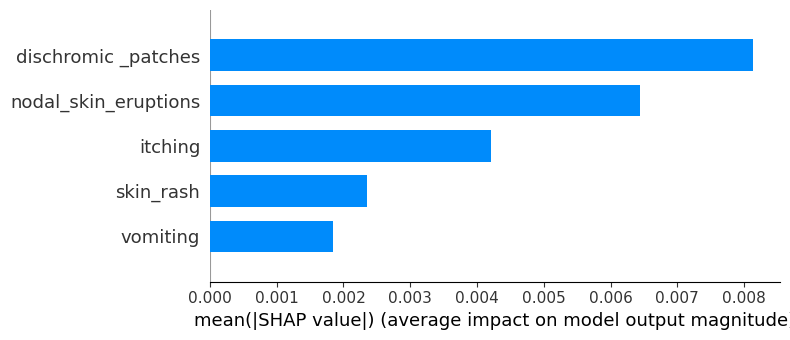


Feature importances for label: AIDS


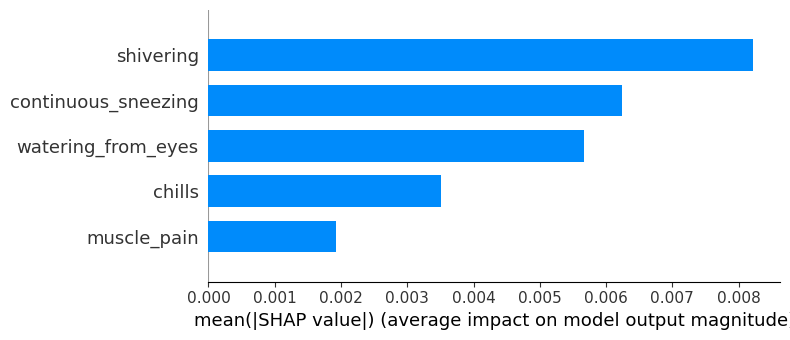


Feature importances for label: Acne


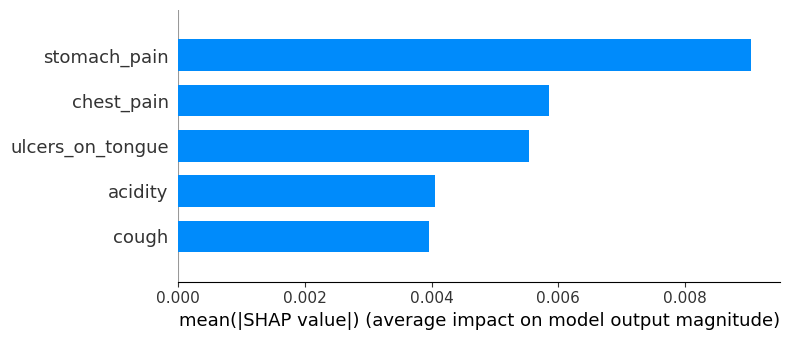


Feature importances for label: Alcoholic hepatitis


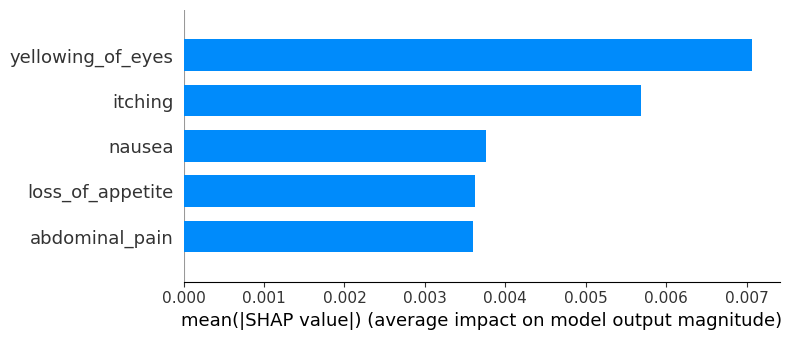


Feature importances for label: Allergy


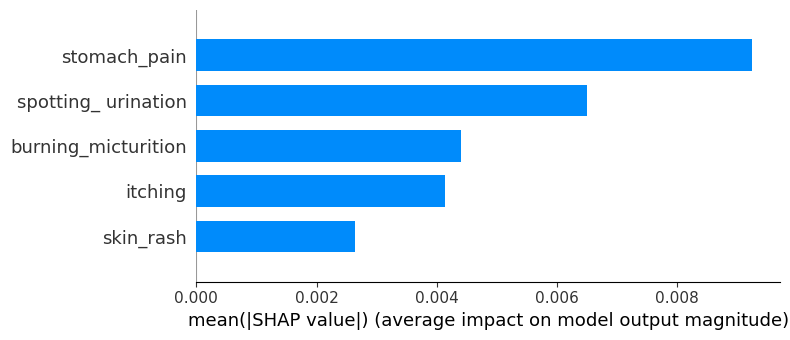


Feature importances for label: Arthritis


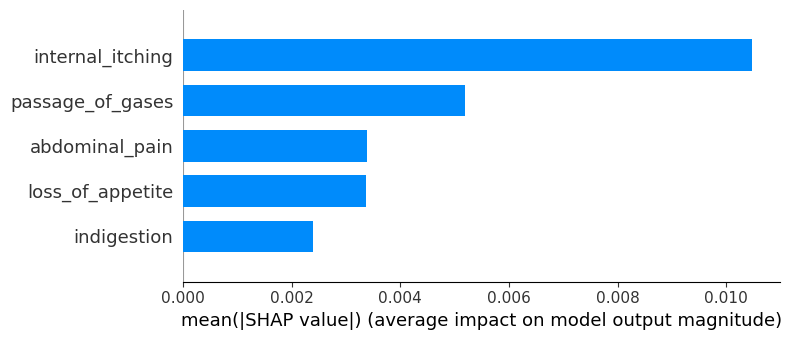


Feature importances for label: Bronchial Asthma


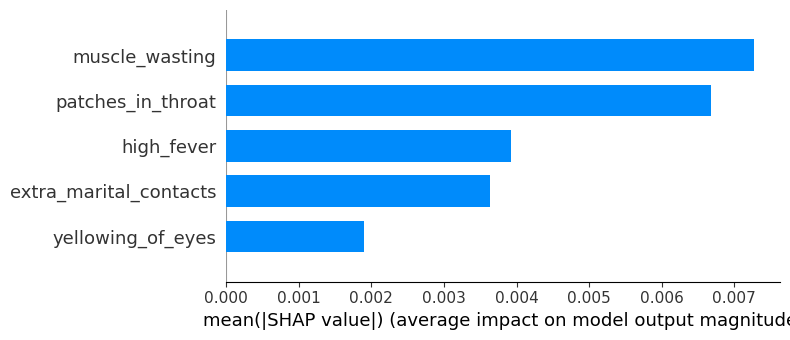


Feature importances for label: Cervical spondylosis


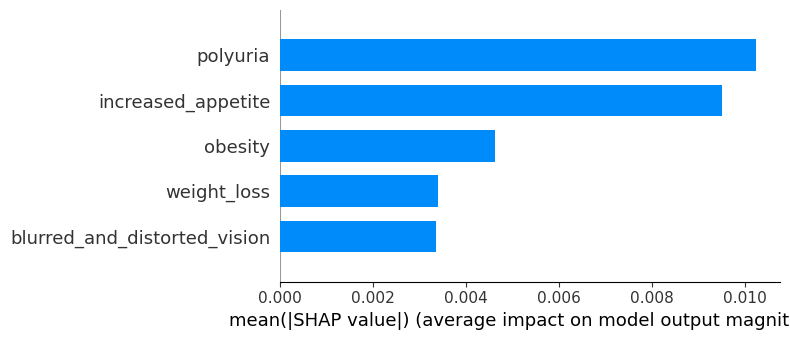


Feature importances for label: Chicken pox


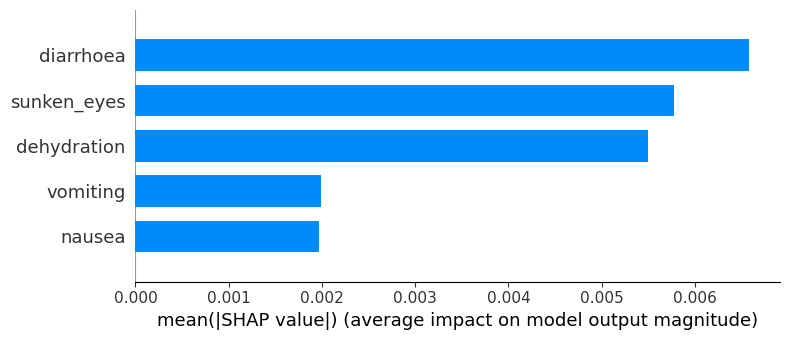


Feature importances for label: Chronic cholestasis


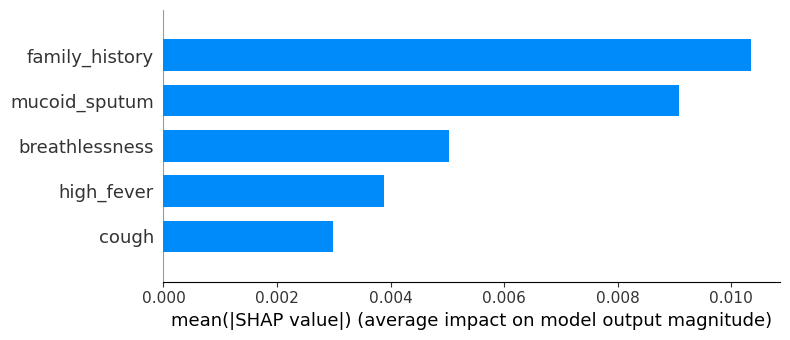


Feature importances for label: Common Cold


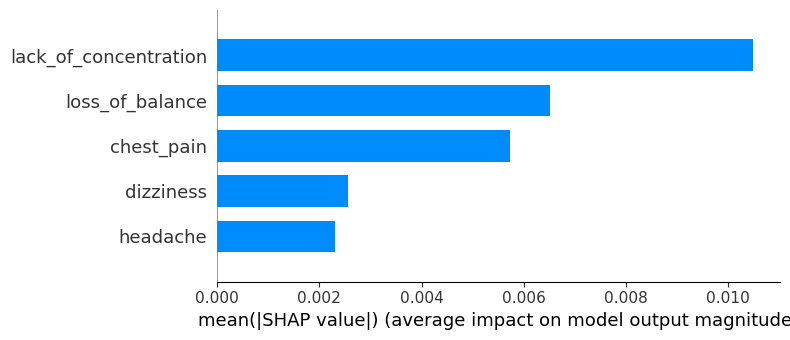


Feature importances for label: Dengue


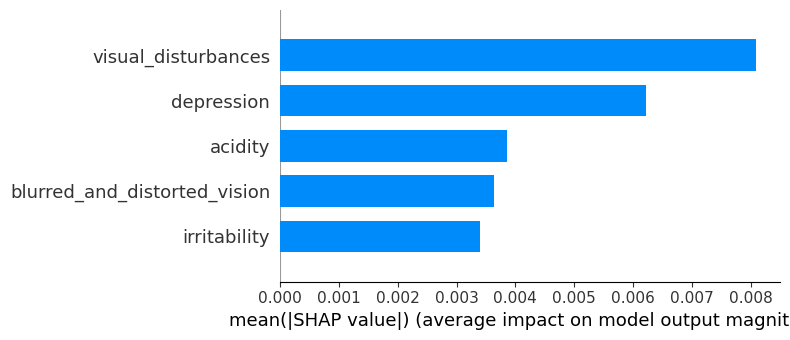


Feature importances for label: Diabetes 


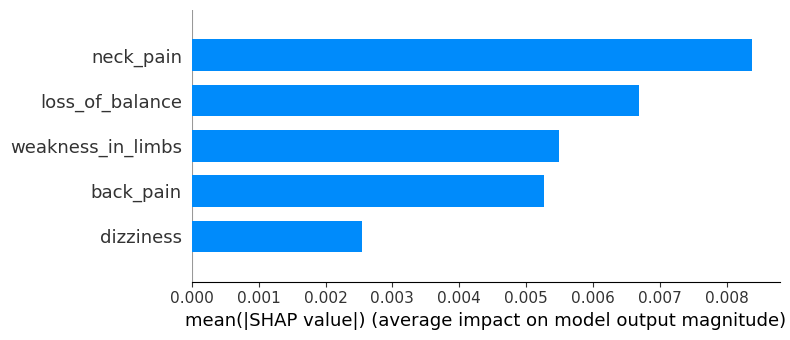


Feature importances for label: Dimorphic hemmorhoids(piles)


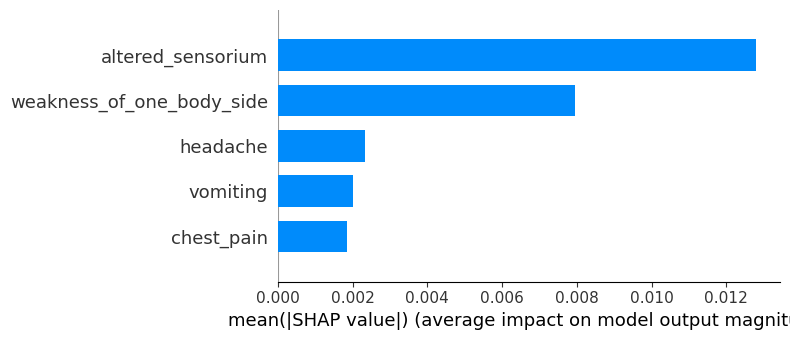


Feature importances for label: Drug Reaction


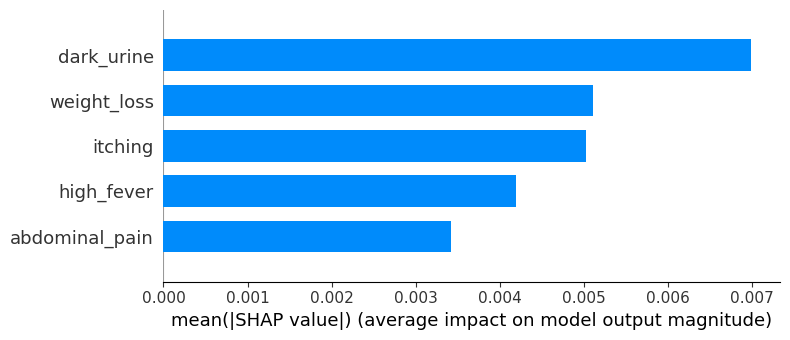


Feature importances for label: Fungal infection


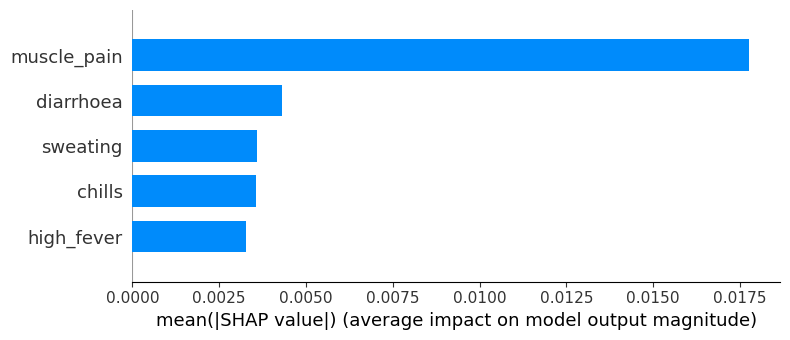


Feature importances for label: GERD


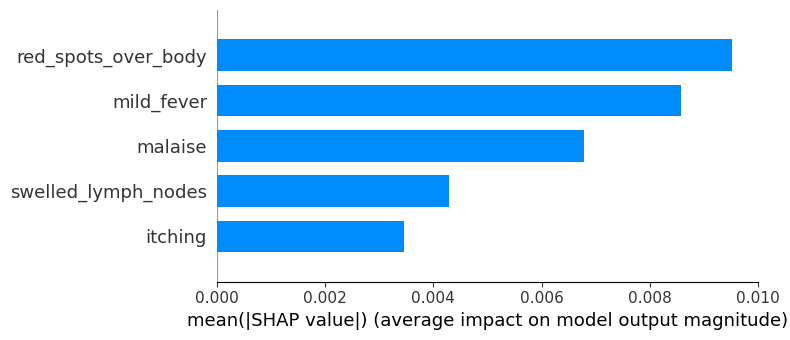


Feature importances for label: Gastroenteritis


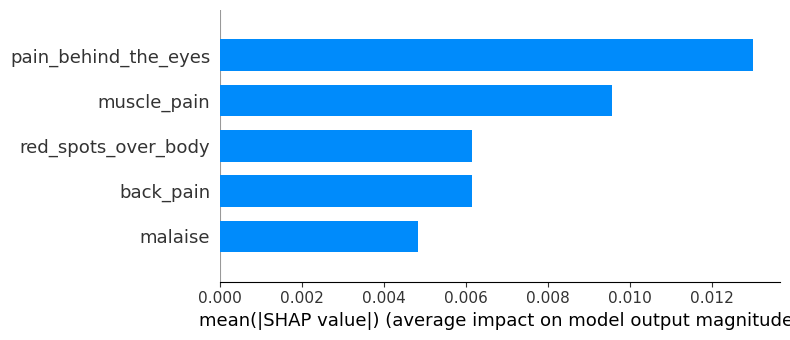


Feature importances for label: Heart attack


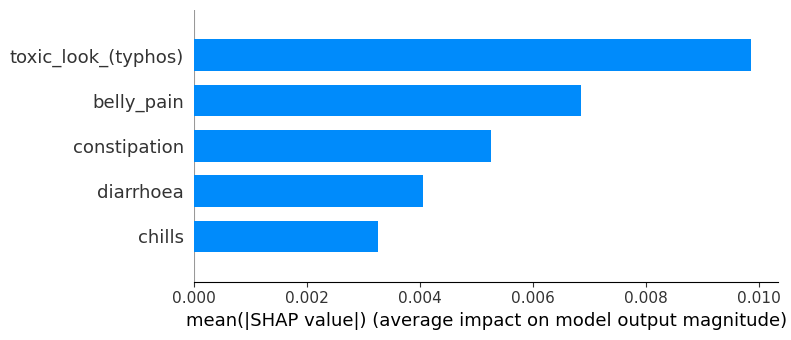


Feature importances for label: Hepatitis B


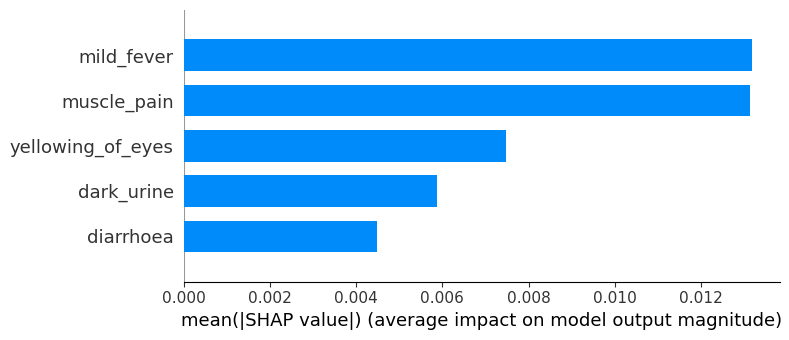


Feature importances for label: Hepatitis C


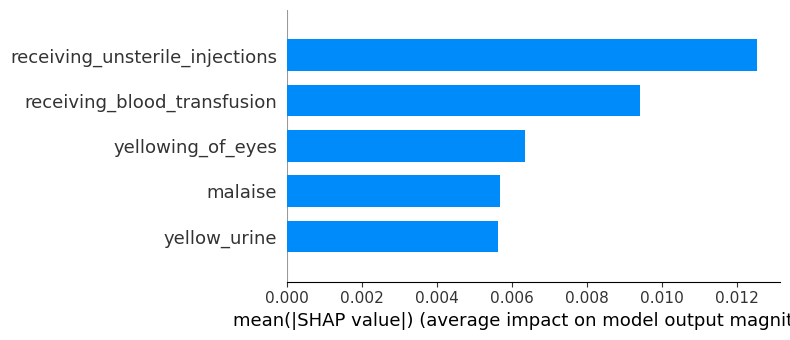


Feature importances for label: Hepatitis D


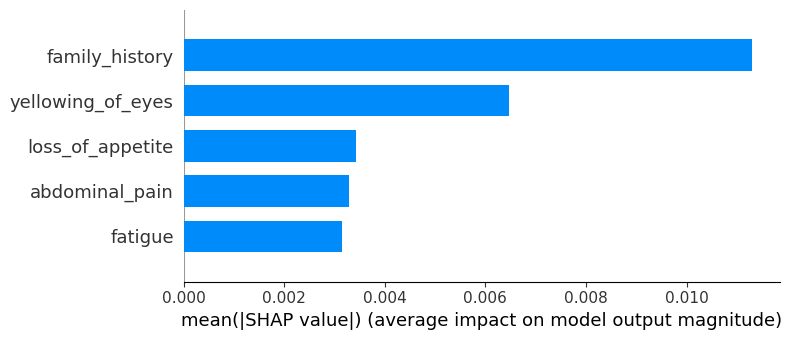


Feature importances for label: Hepatitis E


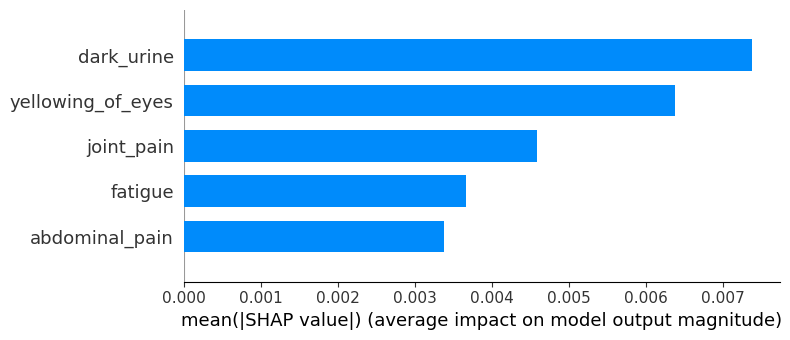


Feature importances for label: Hypertension 


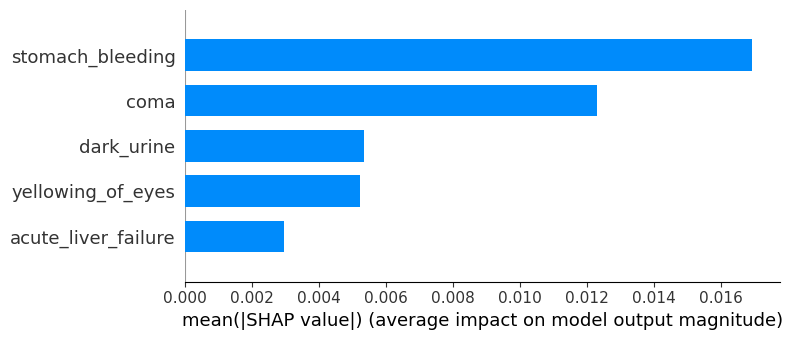


Feature importances for label: Hyperthyroidism


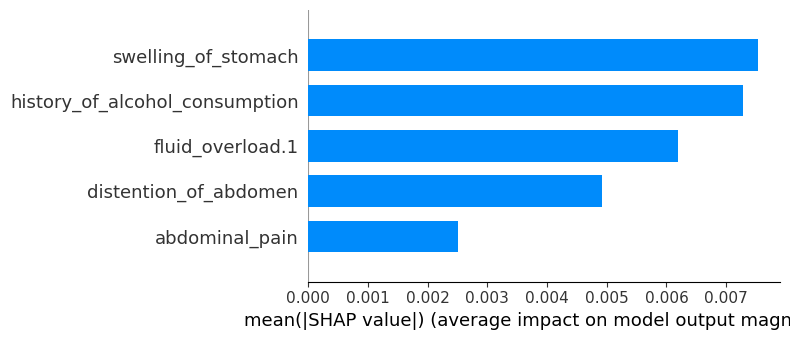


Feature importances for label: Hypoglycemia


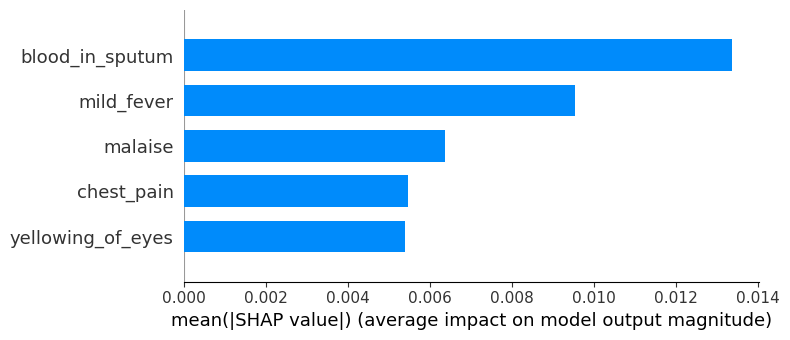


Feature importances for label: Hypothyroidism


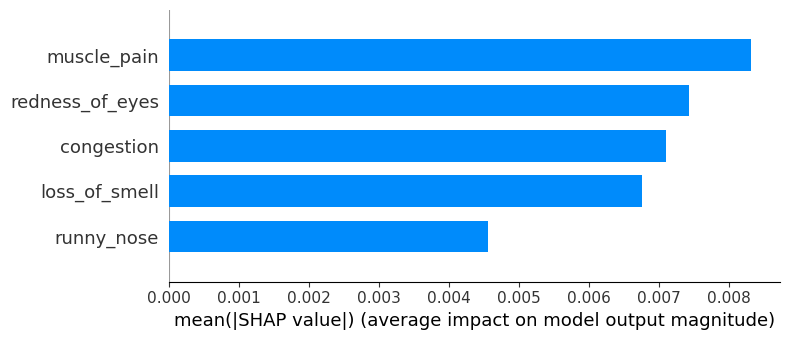


Feature importances for label: Impetigo


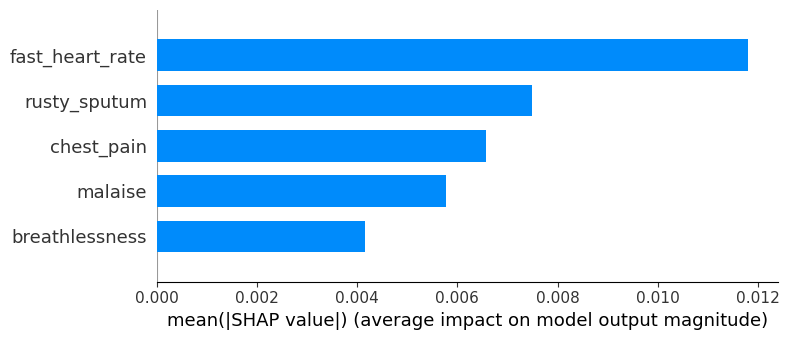


Feature importances for label: Jaundice


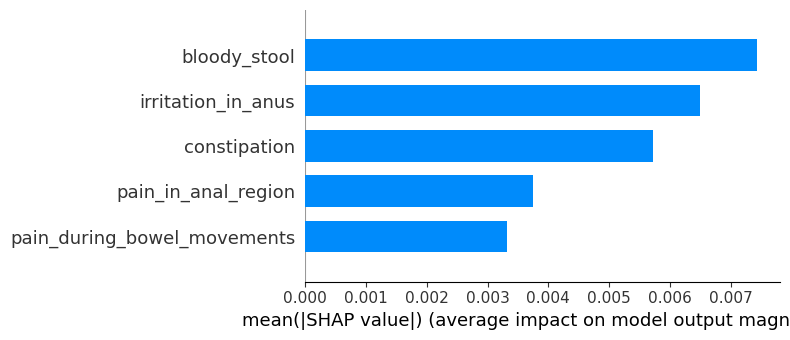


Feature importances for label: Malaria


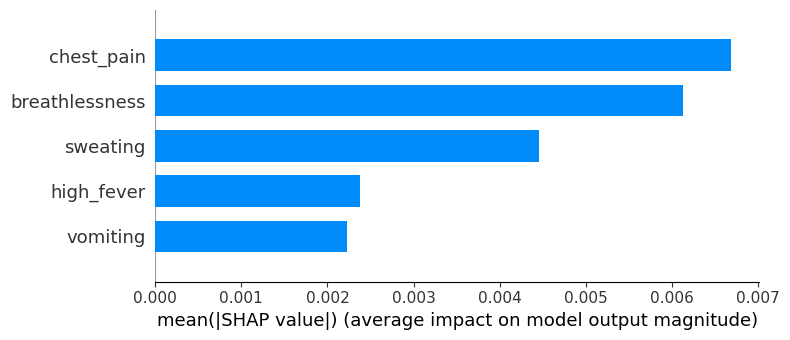


Feature importances for label: Migraine


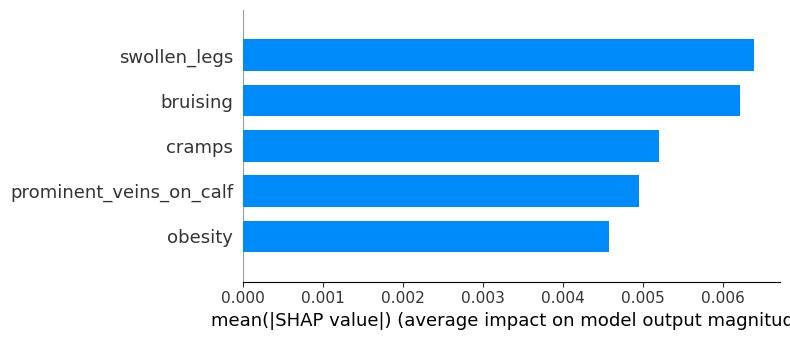


Feature importances for label: Osteoarthristis


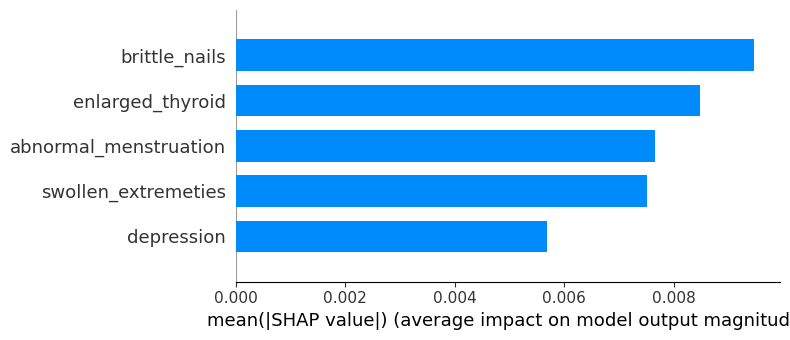


Feature importances for label: Paralysis (brain hemorrhage)


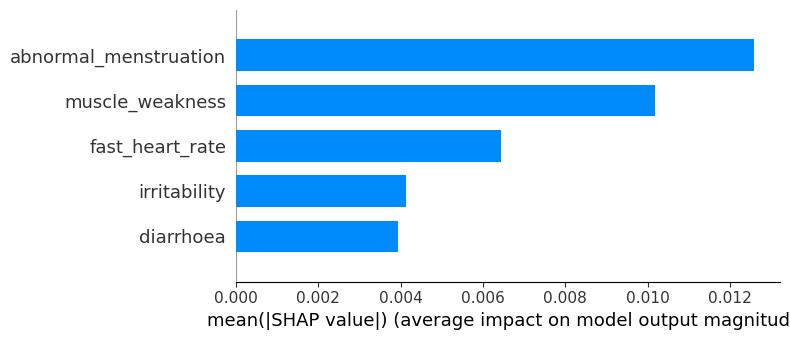


Feature importances for label: Peptic ulcer diseae


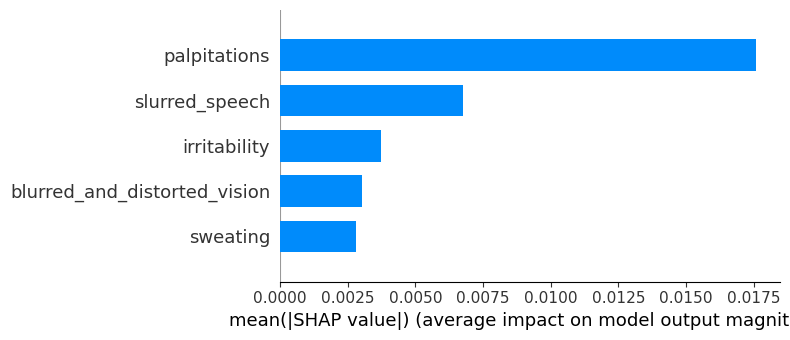


Feature importances for label: Pneumonia


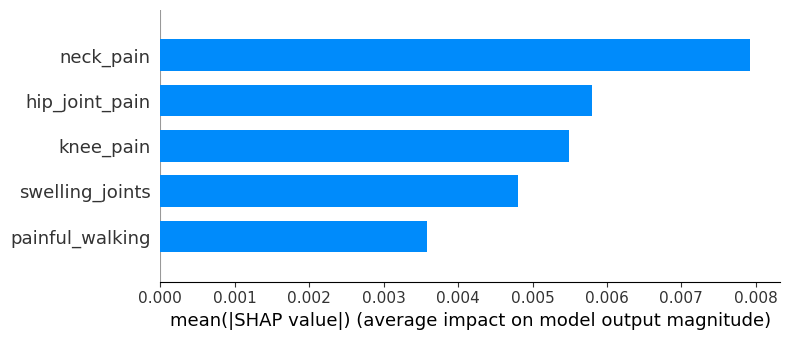


Feature importances for label: Psoriasis


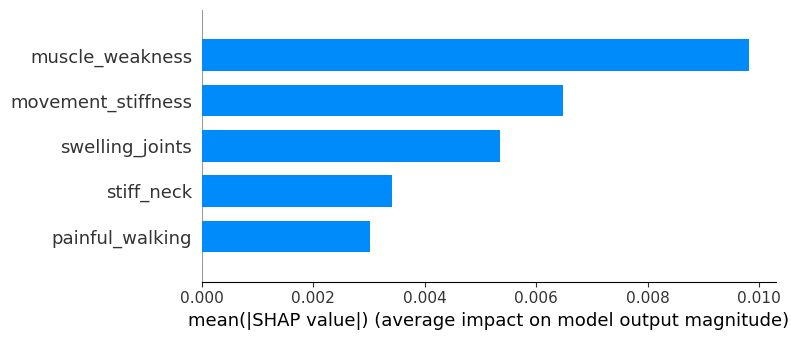


Feature importances for label: Tuberculosis


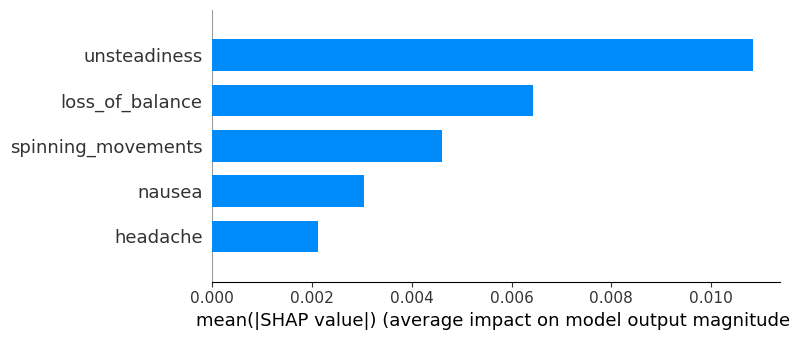


Feature importances for label: Typhoid


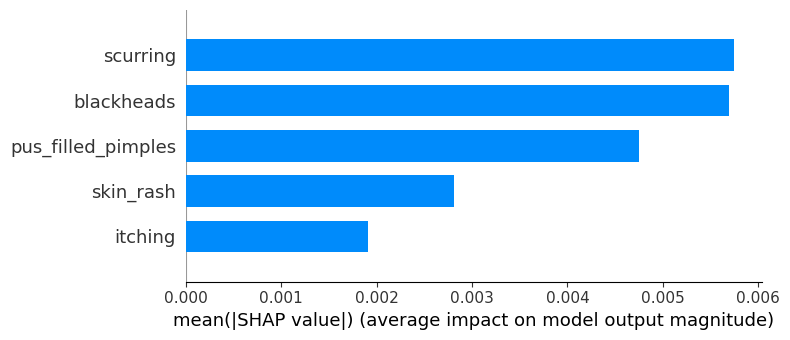


Feature importances for label: Urinary tract infection


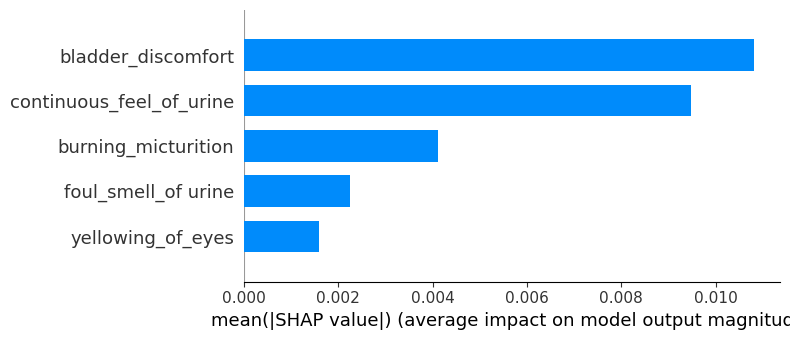


Feature importances for label: Varicose veins


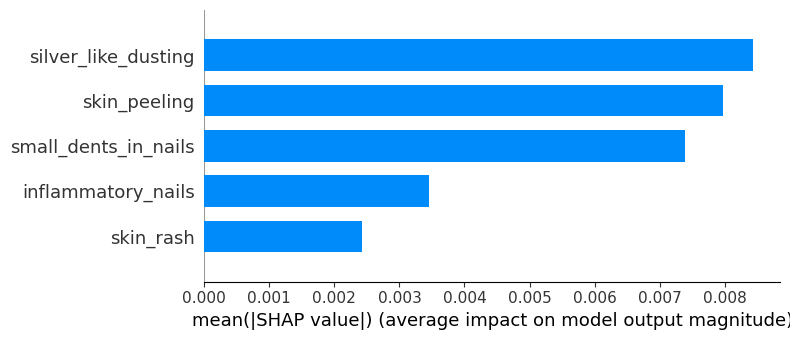


Feature importances for label: hepatitis A


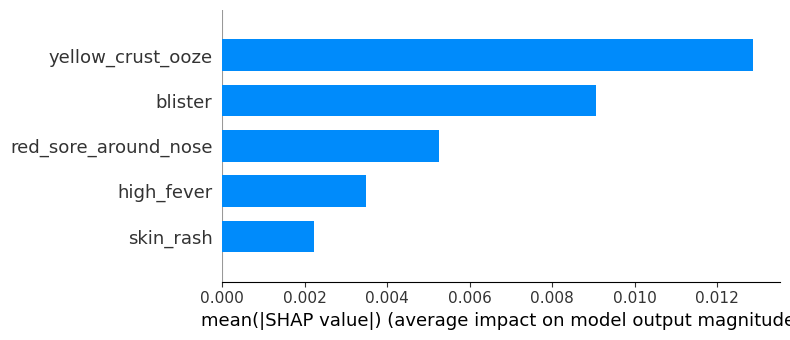

In [67]:
import shap

# Use the Random Forest pre-trained model
classifier = best_model_D.named_steps['classifier']

# Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)

# Get the original labels of the data back
original_labels = target_encoder.inverse_transform(classifier.classes_)

# Display feature importance for each class label
for i, class_name in enumerate(original_labels):
    print(f"\nFeature importances for label: {class_name}")
    shap.summary_plot(shap_values[i].T, X_test, plot_type="bar", max_display=5)

# Optionally display summary plot for more detailed insights
#shap.summary_plot(shap_values, X_test)


#### The SHAP Values generated with the random Forest model was able to predict the 5 most important features for the 41 conditions to give a better prognosis of the disease condition.

## Saving the Best Model ##

In [ ]:
#save the best model as a pickle file
import os
import pickle

# Define the directory and file name
folder_path = r"C:\Users\Dell\my_directory\disease_prediction\experiments\Models"
file_name = "Roha_best_model.pkl"

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Full file path
file_path = os.path.join(folder_path, file_name)

# Save the best estimator
with open(file_path, 'wb') as file:
    pickle.dump(grid_search_B.best_estimator_, file)

print(f"Best model saved successfully at {file_path}")


# Summary and Conclusion

After evaluating the five models (**Random Forest**, **XGBoost**, **Decision Tree**, **SVC**, and **Neural Network**), here’s a concise comparison:

- **Neural Network**: 
  - Achieved perfect accuracy (1.0) and F1-scores, but likely overfits due to the small dataset.
  - Lack of AUC-ROC data limits probabilistic evaluation.
  - It’s promising but less reliable for generalization.

- **SVC**:
  - Delivered perfect accuracy (1.0) with balanced precision, recall, and F1-scores.
  - Handles small datasets and high-dimensional data effectively but is computationally expensive for larger datasets.
  - A robust choice for this task.

- **Random Forest**:
  - High accuracy (0.976), interpretable, and robust to overfitting.
  - Slightly lower recall for rare classes like "Fungal infection" (0.5).
  - Performs well on noisy data and is scalable.

- **XGBoost**:
  - Matches Random Forest in accuracy (0.976) with better handling of imbalanced data.
  - Slightly lower recall for certain classes (e.g., "Fungal infection") but offers scalability and efficiency.

- **Decision Tree**:
  - High accuracy (0.976) with easy interpretability,and quick training time but 
  - Prone to overfitting small datasets, leading to lower recall for rare classes (e.g., "Fungal infection").
  - Best suited for quick insights rather than generalization.

## Recommendation

The **Support Vector Classifier (SVC)** is the best model due to its perfect accuracy and balanced handling of all classes. If interpretability or scalability is a priority, **Random Forest** is a strong alternative, providing robust performance and feature importance insights. Both models are excellent choices, with **SVC** slightly outperforming in this scenario.
